In [1]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange

sys.path.append("../../")
import biked_commons
from biked_commons.api import rendering

Using java as the Java binary
Starting BikeCAD server...
BikeCAD server started.


This builds the overall validation function

In [2]:
from clip_validation_functions import CLIPS_VALIDATIONS
from base_validation_function import construct_tensor_validator, construct_dataframe_validator

Read in the Bike Data

In [3]:
data = pd.read_csv("../../resources/datasets/split_datasets/CLIP_X_test.csv", index_col=0)
display(data)

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,BB diameter,...,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True,BELTorCHAIN OHCLASS: 0,BELTorCHAIN OHCLASS: 1,RIM_STYLE front OHCLASS: DISC,RIM_STYLE front OHCLASS: SPOKED,RIM_STYLE front OHCLASS: TRISPOKE,RIM_STYLE rear OHCLASS: DISC,RIM_STYLE rear OHCLASS: SPOKED,RIM_STYLE rear OHCLASS: TRISPOKE
1,430.00,67.000000,565.6,73.000000,135.6,45.0,588.7,72.500000,664.020690,40.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,350.00,-14.500000,565.6,71.500000,80.0,45.0,265.0,71.500000,572.491950,40.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,415.00,4.000000,565.6,72.000000,198.8,45.0,562.0,74.000000,647.103654,38.1,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,375.00,50.000000,565.6,70.500000,91.8,40.0,460.0,73.500000,573.904093,38.1,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5,431.79,24.000000,565.6,72.100000,83.1,41.0,300.0,72.500000,636.179297,40.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4796,410.00,75.000000,552.0,72.500000,145.0,125.0,520.0,74.000000,644.551458,40.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4797,419.00,42.909345,598.9,65.772099,95.0,90.0,380.0,77.772099,704.278730,40.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4798,410.00,-11.500000,492.5,72.000000,250.0,45.0,550.0,74.000000,547.934671,40.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4799,410.00,-11.500000,500.0,72.000000,280.4,45.0,550.0,74.000532,542.387502,40.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


REQUIRES JAVA 17 OR NEWER. RESTART AFTER INSTALL

C:\Users\Lyler\AppData\Local\Temp\ipykernel_31428\189263255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1["DT Length"] = 800


1.0


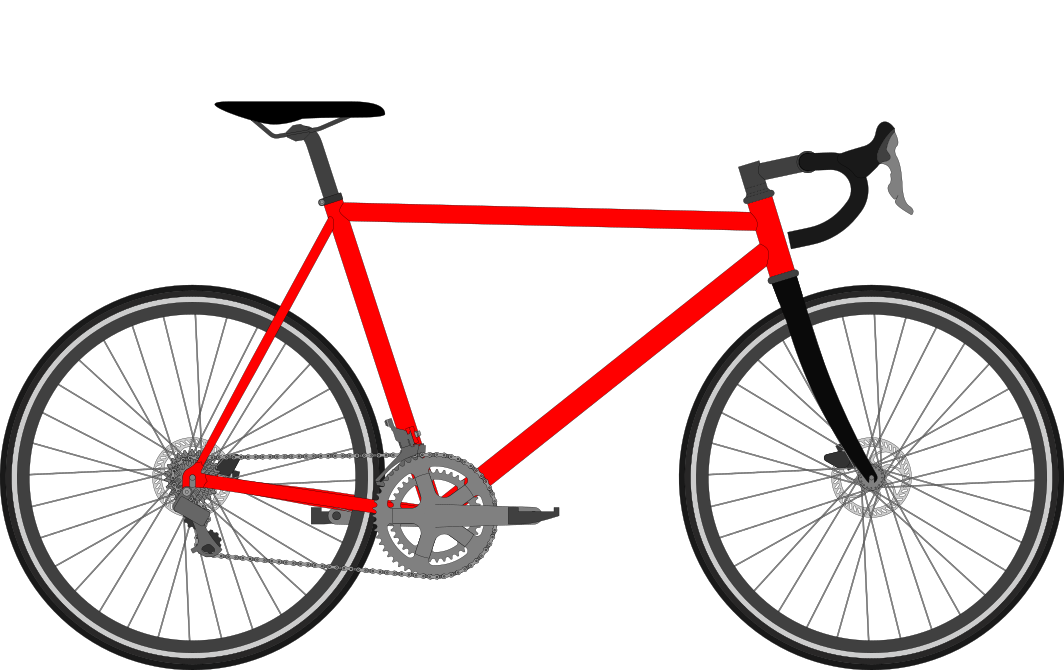

In [5]:
renderer = rendering.SingleThreadedRenderer()
data1 = data.iloc[0]
data1["DT Length"] = 800
print(data1["Handlebar style OHCLASS: 0"])
res = renderer.render_clip(data1)
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

This builds the overall validation function

In [5]:
dataframe_validator = construct_dataframe_validator(CLIPS_VALIDATIONS)

Call the validation function and check the results. Remember, a score less or equal to 0 is valid. The more postive, the greater the magnitude of constraint violation. The more negative the further away from violating the constraint. A design is overall valid if all constraints are less or equal to 0

In [6]:
validity_scores = dataframe_validator(data)
display(validity_scores.head(10)) #design 6's saddle height is too small, for example

,Saddle height too small,Seat post too short,Bsd rear too small,Bsd front too small,Head tube lower extension too great,Head tube length too great,Chain stay less than zero
1,-139.299988,-150.700012,-40.0,-40.0,-85.600006,-45.600006,-430.000000
2,-25.000000,-65.000000,-40.0,-40.0,-56.900002,-33.599998,-350.000000
3,-161.000000,-129.000000,-40.0,-40.0,-162.899994,-126.400002,-415.000000
4,-100.000000,-30.000000,-40.0,-40.0,-57.900002,-28.800003,-375.000000
5,-10.000000,-230.000000,-40.0,-40.0,-28.799999,-8.599998,-431.790009
6,5.000000,-295.000000,-40.0,-40.0,-65.000000,-44.900002,-311.899994
7,-180.000000,-210.000000,-40.0,-40.0,-115.000000,-86.500000,-425.000000
8,-193.000000,-197.000000,-40.0,-40.0,-53.599998,-26.599998,-425.000000
9,-153.599976,-16.400024,-40.0,-40.0,-110.900002,-82.800003,-450.000000
10,-333.000000,43.000000,-40.0,-40.0,-36.900002,-11.000000,-443.000000


In [7]:
#overall valid if all constraints are less or equal to 0

validity = np.all(validity_scores <= 0, axis=1)
print(validity[:10])
print(f"Fraction of valid designs: {np.sum(validity) / len(validity)}")

1      True
2      True
3      True
4      True
5      True
6     False
7      True
8      True
9      True
10    False
dtype: bool
Fraction of valid designs: 0.9042553191489362


C:\Users\Lyle\AppData\Local\Temp\ipykernel_64508\510230081.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  print(validity[:10])


If we want to calculate gradients, we need to use the pytorch version of the validator. 

In [ ]:
COLUMN_NAMES = list(data.columns)
tensor_validator, validation_names = construct_tensor_validator(CLIPS_VALIDATIONS, COLUMN_NAMES)

In [ ]:
print(validation_names)

In [9]:
data_tensor = torch.tensor(data.values, dtype=torch.float32, requires_grad=True)
validity_scores_tens = tensor_validator(data_tensor)
print(validity_scores_tens) # should be the same as the dataframe version

loss = validity_scores_tens[validity_scores_tens > 0].sum() # we make our objective function equal to the sum of constraint violation
loss.backward()
gradients = data_tensor.grad
gradient_df = pd.DataFrame(gradients.numpy(), columns=COLUMN_NAMES, index = data.index)

tensor([[-139.3000, -150.7000,  -40.0000,  ...,  -85.6000,  -45.6000,
         -430.0000],
        [ -25.0000,  -65.0000,  -40.0000,  ...,  -56.9000,  -33.6000,
         -350.0000],
        [-161.0000, -129.0000,  -40.0000,  ..., -162.9000, -126.4000,
         -415.0000],
        ...,
        [-150.0000, -170.0000,  -40.0000,  ..., -210.4000, -153.2000,
         -410.0000],
        [-150.0000, -170.0000,  -40.0000,  ..., -269.6000, -222.4000,
         -410.0000],
        [-150.7000, -169.3000,  -40.0000,  ..., -106.2000,  -82.9000,
         -440.0000]], grad_fn=<CopySlices>)


The gradients tell us how to adjust the parameters to ideally fix the problem

In [10]:
display(gradient_df.head(10)) # we can see that there are some gradients in the seat tube length column, for example

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,BB diameter,...,bottle DOWNTUBE0 show OHCLASS: False,bottle DOWNTUBE0 show OHCLASS: True,BELTorCHAIN OHCLASS: 0,BELTorCHAIN OHCLASS: 1,RIM_STYLE front OHCLASS: DISC,RIM_STYLE front OHCLASS: SPOKED,RIM_STYLE front OHCLASS: TRISPOKE,RIM_STYLE rear OHCLASS: DISC,RIM_STYLE rear OHCLASS: SPOKED,RIM_STYLE rear OHCLASS: TRISPOKE
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Test gradient descent to see if validity improves

In [11]:
updated_data = data
step_size = 0.1
for steps in trange(1000):
    #calculate gradients
    data_tensor = torch.tensor(updated_data.values, dtype=torch.float32, requires_grad=True)
    validity_scores_tens = tensor_validator(data_tensor)
    loss = validity_scores_tens[validity_scores_tens > 0].sum()
    loss.backward()
    gradients = data_tensor.grad
    gradients = gradients.numpy()
    updated_data = updated_data - step_size * gradients

100%|██████████| 1000/1000 [00:06<00:00, 153.53it/s]


In [12]:
#check validity of updated data
validity_scores = dataframe_validator(updated_data)
validity = np.all(validity_scores <= 0, axis=1)
print(validity.mean())

0.9946808510638298


In [13]:
display(validity_scores.head(10))


,Saddle height too small,Seat post too short,Bsd rear too small,Bsd front too small,Head tube lower extension too great,Head tube length too great,Chain stay less than zero
1,-139.299988,-150.700012,-40.0,-40.0,-85.600006,-45.600006,-430.000000
2,-25.000000,-65.000000,-40.0,-40.0,-56.900002,-33.599998,-350.000000
3,-161.000000,-129.000000,-40.0,-40.0,-162.899994,-126.400002,-415.000000
4,-100.000000,-30.000000,-40.0,-40.0,-57.900002,-28.800003,-375.000000
5,-10.000000,-230.000000,-40.0,-40.0,-28.799999,-8.599998,-431.790009
6,0.000000,-290.000000,-40.0,-40.0,-65.000000,-44.900002,-311.899994
7,-180.000000,-210.000000,-40.0,-40.0,-115.000000,-86.500000,-425.000000
8,-193.000000,-197.000000,-40.0,-40.0,-53.599998,-26.599998,-425.000000
9,-153.599976,-16.400024,-40.0,-40.0,-110.900002,-82.800003,-450.000000
10,-304.199982,-0.200012,-40.0,-40.0,-36.900002,-11.000000,-443.000000


In [14]:
margin = 0.05
parameter_ranges = np.max(data.values, axis=0) - np.min(data.values, axis=0)
lower_bounds = np.min(data.values, axis=0)-margin*parameter_ranges
upper_bounds = np.max(data.values, axis=0)+margin*parameter_ranges

#randomly sample a design
random_design = np.random.uniform(lower_bounds, upper_bounds)

#check validity of random design

validity_scores = dataframe_validator(pd.DataFrame(random_design.reshape(1, -1), columns=COLUMN_NAMES))
display(validity_scores) # should be all less than or equal to 0


,Saddle height too small,Seat post too short,Bsd rear too small,Bsd front too small,Head tube lower extension too great,Head tube length too great,Chain stay less than zero
0,289.8255,-615.028809,894.129822,607.489075,-1235.774292,-880.035095,-1820.843628


Strategies moving forward:

Checking some of the hard-coded values and tuning those a bit:
    Identify some of the designs that are near the boundary, and then essentially adjust the boundary with a little bit of trial and error
    (could potentially procedurally generate a lot of designs to find some that are close) 

Adding missing constraints
    Look at a lot of designs and try to visually spot any issues
    This will take a bit of logical reasoning and understanding of the parameter space (I can potentially recommend some parameters to look at if you show me an example of the issue)


Just do some gradient descent, make sure the gradients work, feed some invalid designs into the gradient-based optimization, look at the before and after and confirm that the optimization fixed the problem


General pointers
Make sure to use vectorized code rather than loops when possible (dont feed in designs one by one into the validation, instead pass in a 2D matrix of the designs)